<h2>Importing Libraries</h2>

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip3 install pyldavis==2.1.2
!pip3 install scikit-learn==0.24.2

In [4]:
import re, nltk, spacy, string

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

import pandas as pd
import seaborn as sns

In [5]:
import os
os.getcwd()

'C:\\Users\\Sunny\\Desktop\\Master\\Sem3\\5212\\A1\\Dataset_Assignment1'

<h2>P1 1000</h2>

<h3>Loading data</h3>

In [6]:
df1000 = pd.read_csv("train_1000.csv")

In [7]:
text_data = []
df = df1000.copy()
docs = df['abstract'].tolist()
print(len(docs))
print(docs[0][0:500])
raw_docs = docs.copy()

1000
  From diagnosing neovascular diseases to detecting white matter lesions
accurate tiny vessel segmentation in fundus images is critical. Promising
results for accurate vessel segmentation have been known. However their
effectiveness in segmenting tiny vessels is still limited. In this paper we
study retinal vessel segmentation by incorporating tiny vessel segmentation
into our framework for the overall accurate vessel segmentation. To achieve
this we propose a new deep convolutional neural netwo


<h3>Pre-processing: Tokenization, filtering, and lemmatization</h3>

In [8]:
# Tokenize the documents.
from nltk.tokenize import RegexpTokenizer

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

# Remove words that are only one character.
docs = [[token for token in doc if len(token) > 1] for doc in docs]

In [9]:
import nltk
nltk.download('wordnet')
# Lemmatize the documents.
from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Sunny\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<h3>Adding Birgrams and Trigrams</h3>

In [10]:
# !pip3 install gensim
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

<h3>Creating corpus</h3>

In [11]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]


print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 991
Number of documents: 1000


In [12]:
if len(corpus) == 0 or len(dictionary) == 0:
    print("Error: Corpus or dictionary is empty.")
else:
    print(f"Corpus size: {len(corpus)}, Dictionary size: {len(dictionary)}")

Corpus size: 1000, Dictionary size: 991


<h3>Getting best NUM_TOPICS</h3>

Now processing LDA model with 10 number of topics
Now processing LDA model with 12 number of topics
Now processing LDA model with 14 number of topics
Best number of topics: 10, average topic coherence: -1.4244296798847653


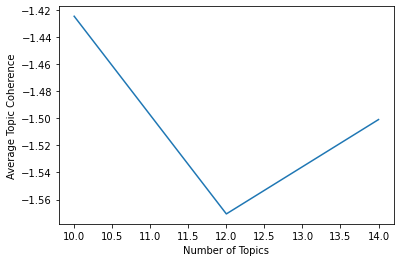

In [13]:
# Train LDA model.
# Import the necessary libraries
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LdaModel

# Set training parameters.
NUM_TOPICS = 30
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Initialize variables
best_avg_topic_coherence = -100
best_num_topics = 0
avg_topic_coherence_values = []

# Define the range of values for NUM_TOPICS you want to explore
num_topics_range = range(10, 16, 2)  # In this example, we'll try values from 10 to 30, with a step of 2

# Loop through each value in the range
for num_topics in num_topics_range:
    print(f"Now processing LDA model with {num_topics} number of topics")
    temp = dictionary[0]
    id2word = dictionary.id2token
    # Train the LDA model with the current value of NUM_TOPICS
    model = LdaModel(
        corpus=corpus,
        id2word=id2word,
        chunksize=chunksize,
        alpha='auto',
        eta='auto',
        iterations=iterations,
        num_topics=num_topics,
        passes=passes,
        eval_every=eval_every
    )

    # Get top_topics and calculate average topic coherence
    top_topics = model.top_topics(corpus)
    avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics

    # Store the average topic coherence value for the current number of topics
    avg_topic_coherence_values.append(avg_topic_coherence)

    # Update the best values if the current average topic coherence is higher than the previous best
    if avg_topic_coherence > best_avg_topic_coherence:
        best_avg_topic_coherence = avg_topic_coherence
        best_num_topics = num_topics
        best_model = model

# Print the best value of NUM_TOPICS and the corresponding average topic coherence value
print(f"Best number of topics: {best_num_topics}, average topic coherence: {best_avg_topic_coherence}")

# Plot the average topic coherence values for different numbers of topics
plt.plot(num_topics_range, avg_topic_coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Average Topic Coherence")
plt.show()


<h3>Training LDA</h3>

In [14]:
# # Train LDA model.
# from gensim.models import LdaModel

# # Set training parameters.
# NUM_TOPICS = 12
# chunksize = 2000
# passes = 20
# iterations = 400
# eval_every = None  # Don't evaluate model perplexity, takes too much time.

# temp = dictionary[0]
# id2word = dictionary.id2token

# model = LdaModel(
#     corpus=corpus,
#     id2word=id2word,
#     chunksize=chunksize,
#     alpha='auto',
#     eta='auto',
#     iterations=iterations,
#     num_topics=NUM_TOPICS,
#     passes=passes,
#     eval_every=eval_every
# )
# outputfile = f'model{NUM_TOPICS}.gensim'
# print("Saving model in " + outputfile)
# # print("")
# # model.save(outputfile)

In [15]:
model = best_model

<h3>Calculating and printing average topic coherence</h3>

In [16]:
top_topics = model.top_topics(corpus) #, num_words=20)
model.num_topics

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / NUM_TOPICS
print('Average topic coherence: %.4f.' % avg_topic_coherence)

Average topic coherence: -0.4748.


<h3> Printint out topics</h3>

In [17]:
model.print_topics( num_words=20)

[(0,
  '0.025*"algorithm" + 0.014*"problem" + 0.012*"data" + 0.011*"number" + 0.011*"approach" + 0.011*"number_of" + 0.010*"new" + 0.010*"which" + 0.010*"based" + 0.009*"it" + 0.009*"show" + 0.008*"our" + 0.008*"set" + 0.008*"from" + 0.007*"method" + 0.007*"paper" + 0.007*"have" + 0.007*"one" + 0.006*"in_this" + 0.006*"frame"'),
 (1,
  '0.029*"method" + 0.017*"face" + 0.014*"3d" + 0.013*"pose" + 0.012*"our" + 0.010*"which" + 0.009*"training" + 0.009*"state" + 0.008*"can" + 0.008*"model" + 0.008*"state_of" + 0.008*"art" + 0.008*"proposed" + 0.008*"based" + 0.008*"camera" + 0.008*"code" + 0.007*"problem" + 0.007*"be" + 0.007*"available" + 0.007*"accuracy"'),
 (2,
  '0.017*"image" + 0.017*"method" + 0.016*"it" + 0.015*"based" + 0.014*"proposed" + 0.013*"problem" + 0.010*"algorithm" + 0.010*"which" + 0.010*"based_on" + 0.009*"can" + 0.009*"be" + 0.009*"one" + 0.008*"approach" + 0.008*"paper" + 0.008*"classification" + 0.008*"ha" + 0.007*"classifier" + 0.007*"used" + 0.007*"between" + 0.007

<h3>Visualizing topics using pyLDAvis</h3>

In [18]:
# !pip install pyLDAvis==2.1.2
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

<h3>Creating a dataframe with dominant topics for each document</h3>

In [ ]:
def get_document_topics(ldamodel=model, corpus=corpus, texts=raw_docs):
   # Init output
    document_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                document_topics_df = document_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    document_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    document_topics_df = pd.concat([document_topics_df, contents], axis=1)

    document_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Original_Text']

    return document_topics_df
doc_topic_df = get_document_topics(ldamodel=model, corpus=corpus, texts=raw_docs)


In [ ]:
doc_topic_df.head()

In [ ]:
# Group top 5 sentences under each topic
doc_topics_sorted_df = pd.DataFrame()

doc_topic_df_grpd = doc_topic_df.groupby('Dominant_Topic')

for i, grp in doc_topic_df_grpd:
    doc_topics_sorted_df = pd.concat([doc_topics_sorted_df, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

doc_topics_sorted_df.reset_index(drop=True, inplace=True)
doc_topics_sorted_df.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
doc_topics_sorted_df.head(10)

<h3>Find the most representative document for each topic</h3>


In [ ]:
def find_top_k_doc(doc_topic_df=doc_topic_df, k=5):

    doc_topics_sorted_df = pd.DataFrame()

    doc_topic_df_grpd = doc_topic_df.groupby('Dominant_Topic')

    for i, grp in doc_topic_df_grpd:
        doc_topics_sorted_df = pd.concat([doc_topics_sorted_df, 
                                          grp.sort_values(['Perc_Contribution'], ascending=[0]).head(k)], 
                                          axis=0)

    doc_topics_sorted_df.reset_index(drop=True, inplace=True)
    doc_topics_sorted_df.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
    return doc_topics_sorted_df

top_k_df = find_top_k_doc()
top_k_df

from pprint import pprint
T = 2
for index, row in top_k_df[top_k_df['Topic_Num']==T].iterrows():

    print("Doc Contribution is %d" , row["Topic_Perc_Contrib"])
    pprint(row["Text"] + "\n-------------------------------------------------")

In [ ]:
import multiprocessing
from multiprocessing import Pool

In [ ]:
import functools
from functools import partial

In [ ]:
from sklearn.model_selection import ParameterGrid
from multiprocessing import Pool
from functools import partial


# Define a parameter grid
param_grid = {
    'num_topics': [10, 12, 14, 16],
    'alpha': ['auto', 0.1, 0.01],
    'eta': ['auto', 0.1, 0.01],
    'passes': [10, 20, 30],
    'iterations': [200, 400, 600]
}

grid = ParameterGrid(param_grid)

best_params = {}
best_coherence = -100

# for params in grid:
#     model = LdaModel(
#         corpus=corpus,
#         id2word=id2word,
#         chunksize=chunksize,
#         alpha=params['alpha'],
#         eta=params['eta'],
#         iterations=params['iterations'],
#         num_topics=params['num_topics'],
#         passes=params['passes'],
#         eval_every=eval_every
#     )
    
#     top_topics = model.top_topics(corpus)
#     avg_topic_coherence = sum([t[1] for t in top_topics]) / params['num_topics']
    
#     if avg_topic_coherence > best_coherence:
#         best_coherence = avg_topic_coherence
#         best_params = params

# print(f"Best parameters: {best_params}")



In [ ]:
from multiprocessing import Pool
from functools import partial

def train_lda_model(params, corpus, id2word, chunksize, eval_every):
    model = LdaModel(
        corpus=corpus,
        id2word=id2word,
        chunksize=chunksize,
        alpha=params['alpha'],
        eta=params['eta'],
        iterations=params['iterations'],
        num_topics=params['num_topics'],
        passes=params['passes'],
        eval_every=eval_every
    )
    
    print(params)
    
    top_topics = model.top_topics(corpus)
    avg_topic_coherence = sum([t[1] for t in top_topics]) / params['num_topics']
    
    return (params, avg_topic_coherence)

# Modify the train_lda_model function call in the loop
with Pool() as pool:
    results = pool.map(
        partial(train_lda_model, corpus=corpus, id2word=id2word, chunksize=chunksize, eval_every=eval_every),
        grid
    )

best_params, best_coherence = max(results, key=lambda x: x[1])
print(f"Best parameters: {best_params}")

In [19]:
import concurrent.futures
from sklearn.model_selection import ParameterGrid

# Define a parameter grid
param_grid = {
    'num_topics': [10, 12, 14, 16],
    'alpha': ['auto', 0.1, 0.01],
    'eta': ['auto'],
    'passes': [10],
    'iterations': [200]
}

grid = ParameterGrid(param_grid)

def train_lda_model(params, corpus, id2word, chunksize, eval_every):
    model = LdaModel(
        corpus=corpus,
        id2word=id2word,
        chunksize=chunksize,
        alpha=params['alpha'],
        eta=params['eta'],
        iterations=params['iterations'],
        num_topics=params['num_topics'],
        passes=params['passes'],
        eval_every=eval_every
    )
    print(params)
    top_topics = model.top_topics(corpus)
    avg_topic_coherence = sum([t[1] for t in top_topics]) / params['num_topics']
    
    return (params, avg_topic_coherence, model)


{'alpha': 0.01, 'eta': 'auto', 'iterations': 200, 'num_topics': 10, 'passes': 10}
{'alpha': 'auto', 'eta': 'auto', 'iterations': 200, 'num_topics': 10, 'passes': 10}
{'alpha': 0.1, 'eta': 'auto', 'iterations': 200, 'num_topics': 10, 'passes': 10}
{'alpha': 0.01, 'eta': 'auto', 'iterations': 200, 'num_topics': 12, 'passes': 10}
{'alpha': 0.01, 'eta': 'auto', 'iterations': 200, 'num_topics': 14, 'passes': 10}
{'alpha': 'auto', 'eta': 'auto', 'iterations': 200, 'num_topics': 12, 'passes': 10}
{'alpha': 'auto', 'eta': 'auto', 'iterations': 200, 'num_topics': 14, 'passes': 10}
{'alpha': 0.1, 'eta': 'auto', 'iterations': 200, 'num_topics': 12, 'passes': 10}
{'alpha': 0.1, 'eta': 'auto', 'iterations': 200, 'num_topics': 14, 'passes': 10}
{'alpha': 0.01, 'eta': 'auto', 'iterations': 200, 'num_topics': 16, 'passes': 10}
{'alpha': 'auto', 'eta': 'auto', 'iterations': 200, 'num_topics': 16, 'passes': 10}
{'alpha': 0.1, 'eta': 'auto', 'iterations': 200, 'num_topics': 16, 'passes': 10}
Best paramet

In [21]:
results

NameError: name 'results' is not defined